# Building intuition with Gaussians.

__Overview__: This lab is meant to get you more comfortable with numpy and start building some intuition for Gaussians and conditional distributions.

__Goals__: Students should:
1. Be familiar with a linear-algebra capable library (e.g. numpy) and use it to carry out a calculation.
2. Understand multivariate Gaussian distributions.
3. Have intuition for how covariances translate to conditional distributions.

To start, we're going to focus on three different 2x2 covariance matrices for a multivariate Gaussian and plot the probability densities they correspond to. Let's set our three covariance matrices and mean.

In [22]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
mu_all = np.zeros(2)
cov_one = np.array([[1.0, 0.5], [0.5, 1.0]])
cov_two = np.array([[1.0, 0.0], [0.0, 1.0]])
cov_three = np.array([[1.0, -0.5], [-0.5, 1.0]])

Next we'll need a function to evaluate the pdf of a multivariate normal distribution. __You must implement this from scratch. You cannot use a library (e.g. scipy) that calculates the pdf for you.__

In [4]:
def multivariate_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray) -> float:
    """
    Calculates the probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.

    Returns:
        Probability density function value at location x_vec.

    Notes:
        You can use any library you want to carry out the linear algebra operations (determinants, matrix multiplication, 
        inversion), but you cannot use a library (e.g. scipy) that calculates the pdf for you. The function should work for
        any dimension of multivariate Gaussian, not just for the 2-dimensional case. Some functions you may find useful:
        - np.linalg.det
        - np.linalg.inv
        - np.exp
        - np.matmul
    """
    # TODO calculate the pdf.
    det_cov = np.linalg.det(covariance_matrix)
    inv_cov = np.linalg.inv(covariance_matrix)
    n = len(x_vec)  
    diff = x_vec - mu_vec
    pdf = (1 / np.sqrt((2 * np.pi) ** n * det_cov)) * np.exp(-0.5 * np.matmul(np.matmul(diff.T, inv_cov), diff))

    return pdf

In [5]:
test_point = np.array([1.01, 0.22])
my_pdf = multivariate_gaussian_pdf(test_point, mu_all, cov_one)
scipy_pdf = stats.multivariate_normal.pdf(test_point, mu_all, cov_one)
assert np.round(my_pdf - scipy_pdf, 6) == 0, "The two values do not agree. Did you forget the terms outside the exponential?"

How does our timing compare to scipy?

In [6]:
%%timeit
multivariate_gaussian_pdf(test_point, mu_all, cov_one)

13.8 μs ± 119 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
%%timeit
stats.multivariate_normal.pdf(test_point, mu_all, cov_one)

70.2 μs ± 1.59 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Let's use matplotlib's contour visualization feature to understand our three pdfs.

If you ran into errors for the following block, please check if your numpy version is up to date.

In [8]:
# We can use numpy's vectorize capability to vectorize our pdf function.
mg_pdf_vectorized = np.vectorize(multivariate_gaussian_pdf, signature='(n), (n), (n,n) -> ()')

# We can also use numpy's meshgrid to get the points to evaluate
x1_points, x2_points = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
x_vec_points = np.stack([x1_points, x2_points], axis=-1)

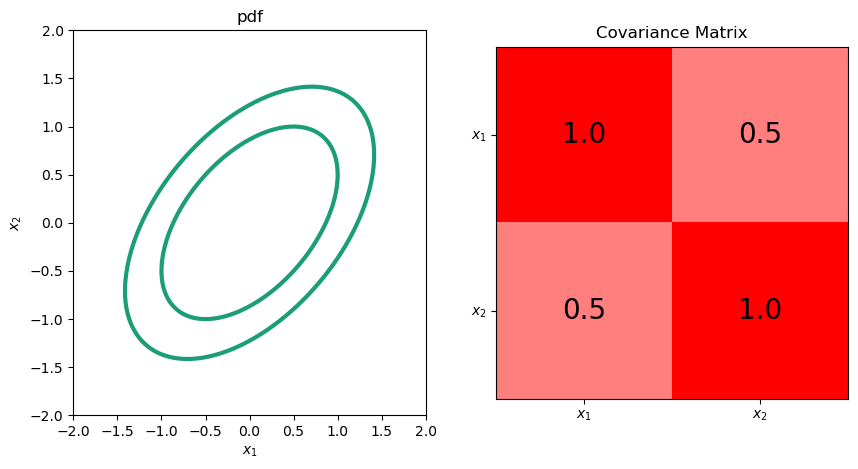

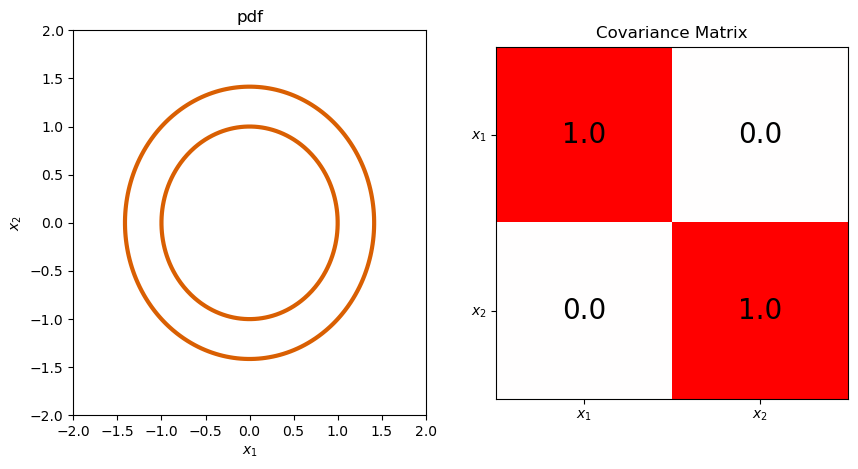

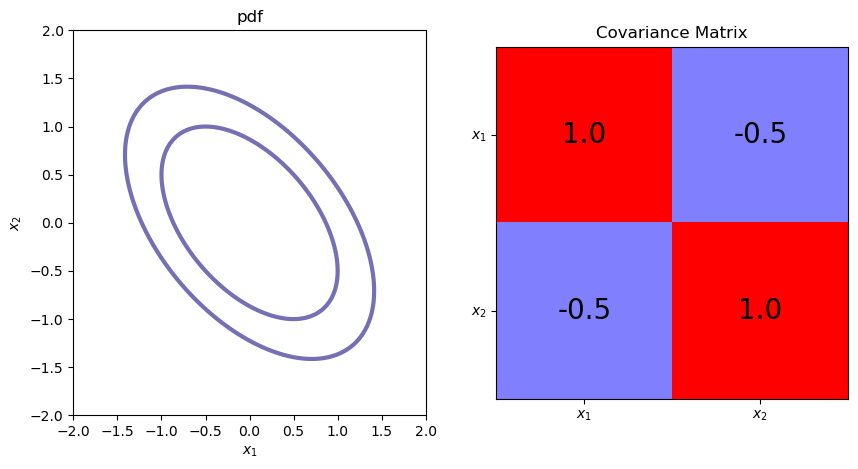

In [9]:
def plot_pdf_and_covariance(covariance_matrix:np.ndarray, color='black'):
    # Use the vectorized function to evaluate the pdf.
    pdf_evaluations = mg_pdf_vectorized(x_vec_points, mu_all, covariance_matrix)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].contour(x1_points, x2_points, pdf_evaluations/np.max(pdf_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors=color, linewidths=3)
    ax[0].set_xlabel(r'$x_1$')
    ax[0].set_ylabel(r'$x_2$')
    ax[0].set_title('pdf')
    ax[1].imshow(covariance_matrix, cmap='bwr', vmax=1, vmin=-1)
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_yticks([0,1])
    ax[1].set_yticklabels([r'$x_1$',r'$x_2$'])
    ax[1].set_title('Covariance Matrix')

    for x_1 in range(2):
        for x_2 in range(2):
            ax[1].text(x_1, x_2, covariance_matrix[x_1, x_2], fontsize=20, ha='center', va='center')
    
    plt.show()

plot_pdf_and_covariance(cov_one, '#1b9e77')
plot_pdf_and_covariance(cov_two, '#d95f02')
plot_pdf_and_covariance(cov_three, '#7570b3')

Now let's see how conditioning on or marginalizing over a specific variable of our multivariate Gaussian changes our distribution. Let's start by writing down the marginalized / conditioned mean and covariance matrix from class. To keep things simple, we'll just marginalize / condition on a __single__ variable.

In [15]:
def marginal_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, marginal_index:int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the marginalized mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        marginal_index: Variable index to marginalize on.

    Returns:
        Mean and covariance of marginalized Gaussian.

    Notes:
        The easiest way to do this is to permute the vector and matrix so that the mariginal_index is the last index.
        Some functions you may find useful beyond the ones you've already used:
        - np.delete
    """
    # TODO calculate the mean and covariance.
    marginal_mean = np.delete(mu_vec, marginal_index)
    marginal_covariance = np.delete(np.delete(covariance_matrix, marginal_index, axis=0), marginal_index, axis=1)

    return marginal_mean, marginal_covariance

def conditioned_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, condition_index:int, 
                                condition_value:float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the conditioned mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        conditioned_index: Variable index to condition on.
        conditioned_value: Value of the variable to condition on.

    Returns:
        Mean and covariance of conditioned Gaussian.

    Notes:
        The easiest way to do this is to permute the vector and matrix so that the condition_index is the last index. 
        Some functions you may find useful beyond the ones you've already used:
        - np.delete
        - np.squeeze
    """   
    # TODO calculate the mean and covariance.
    # Extract the indices of the variables not being conditioned on
    non_condition_indices = np.delete(np.arange(len(mu_vec)), condition_index)
    
    # Extract the relevant submatrices and subvectors
    mu_1 = mu_vec[non_condition_indices]  # Mean of the variables not being conditioned on
    mu_2 = mu_vec[condition_index]  # Mean of the variable being conditioned on
    
    # Partition the covariance matrix
    Sigma_11 = covariance_matrix[np.ix_(non_condition_indices, non_condition_indices)]
    Sigma_12 = covariance_matrix[np.ix_(non_condition_indices, [condition_index])]
    Sigma_21 = covariance_matrix[np.ix_([condition_index], non_condition_indices)]
    Sigma_22 = covariance_matrix[condition_index, condition_index]  # This is a scalar
    
    # Compute the inverse of Sigma_22 (since it's a scalar, this is just 1 / Sigma_22)
    Sigma_22_inv = 1.0 / Sigma_22
    
    # Compute the conditioned mean
    conditioned_mean = mu_1 + np.squeeze(Sigma_12) * Sigma_22_inv * (condition_value - mu_2)
    
    # Compute the conditioned covariance
    conditioned_covariance = Sigma_11 - Sigma_12 * Sigma_22_inv * Sigma_21

    return conditioned_mean, conditioned_covariance

def conditioned_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray,
                             condition_index:int, condition_value:float) -> float:
    """
    Calculates the conditioned probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        conditioned_index: Variable index to condition on.
        conditioned_value: Value of the variable to condition on.

    Returns:
        Probability density function value at location x_vec.
    """
    mu_cond, cov_cond = conditioned_mean_covariance(mu_vec, covariance_matrix, condition_index, condition_value)

    return multivariate_gaussian_pdf(x_vec, mu_cond, cov_cond)

def marginal_gaussian_pdf(x_vec: np.ndarray, mu_vec: np.ndarray, covariance_matrix: np.ndarray,
                             marginal_index:int) -> float:
    """
    Calculates the marginalized probability density function of a multivariate Gaussian.

    Args:
        x_vec: Vector at which to evaluate the pdf.
        mu_vec: Mean of distribution.
        covariance_matrix: Covariance matrix of the distribution.
        marginal_index: Variable index to marginalize on.

    Returns:
        Probability density function value at location x_vec.
    """
    mu_marg, cov_marg = marginal_mean_covariance(mu_vec, covariance_matrix, marginal_index)

    return multivariate_gaussian_pdf(x_vec, mu_marg, cov_marg)

In [16]:
# Let's test our functions to make sure they give the right values.
# This block will output nothing if your code above is correct.
# Test the marginal
mu_four = np.array([0.2, 0.3, -0.2])
cov_four = np.array([[1.0, 0.5, 0.2],[0.5, 1.0, 0.5], [0.2, 0.5, 1.0]])
my_mean, my_covariance = marginal_mean_covariance(mu_four, cov_four, marginal_index=1)
correct_mean, correct_covariance = (np.array([0.2, -0.2]), np.array([[1.0, 0.2],[0.2, 1.0]]))
np.testing.assert_array_almost_equal(my_mean, correct_mean)
np.testing.assert_array_almost_equal(my_covariance, correct_covariance)

# Test the conditional
my_mean, my_covariance = conditioned_mean_covariance(mu_four, cov_four, condition_index=1, condition_value=1.3)
correct_mean, correct_covariance = (np.array([0.7, 0.3]), np.array([[0.75, -0.05],[-0.05, 0.75]]))
np.testing.assert_array_almost_equal(my_mean, correct_mean)
np.testing.assert_array_almost_equal(my_covariance, correct_covariance)

Let's consider our three-dimensional covariance matrix and see how marginalizing changes the distribution.

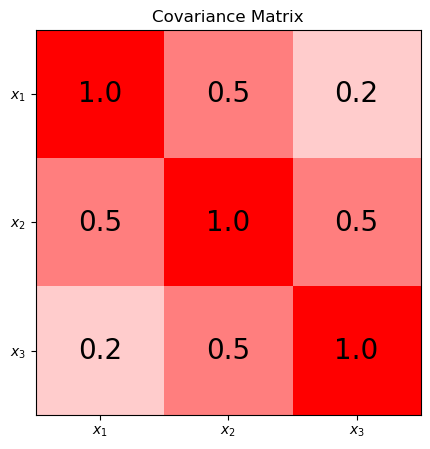

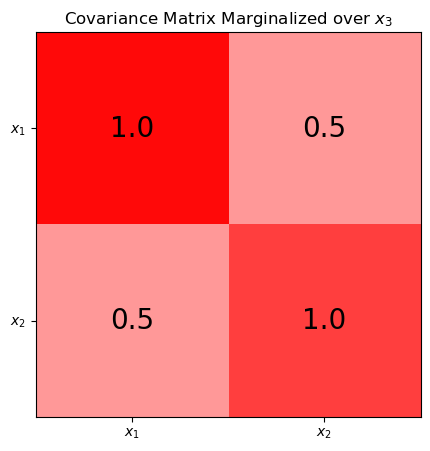

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(cov_four, cmap='bwr', vmax=1, vmin=-1)
ax.set_xticks([0,1,2])
ax.set_xticklabels([r'$x_1$',r'$x_2$',r'$x_3$'])
ax.set_yticks([0,1,2])
ax.set_yticklabels([r'$x_1$',r'$x_2$',r'$x_3$'])
ax.set_title('Covariance Matrix')

for x_1 in range(3):
    for x_2 in range(3):
        ax.text(x_1, x_2, cov_four[x_1, x_2], fontsize=20, ha='center', va='center')

fig, ax = plt.subplots(1, 1, figsize=(10,5))
_, cov_marg_x_three = conditioned_mean_covariance(mu_four, cov_four, condition_index=2, condition_value=0.0)
ax.imshow(cov_marg_x_three, cmap='bwr', vmax=1, vmin=-1)
ax.set_xticks([0,1])
ax.set_xticklabels([r'$x_1$',r'$x_2$'])
ax.set_yticks([0,1])
ax.set_yticklabels([r'$x_1$',r'$x_2$'])
ax.set_title(r'Covariance Matrix Marginalized over $x_3$')

for x_1 in range(2):
    for x_2 in range(2):
        ax.text(x_1, x_2, cov_four[x_1, x_2], fontsize=20, ha='center', va='center')

plt.show()

Stop for a second and think about what you expect when you condition on $x_2$. First, if we condition on a large positive value of $x_2$, how should that change the means of $x_1$ and $x_3$? Second, if we condition on $x_2$, should $x_1$ and $x_3$ become more strongly correlated or anti-correlated? To be more specific, how should $x_3$ change if we increase $x_1$ while conditioning on $x_2$?

In [21]:
# TODO: think about it, then write your guess here. You won't be graded on your guess being correct.
assert False

My guess:

Conditional on x_2 shoud not affect the correlation between x_1 and x_3.

In [19]:
# We can use numpy's vectorize capability to vectorize our pdf function.
mg_pdf_vectorized = np.vectorize(marginal_gaussian_pdf, signature='(n), (m), (m,m), () -> ()')
cg_pdf_vectorized = np.vectorize(conditioned_gaussian_pdf, signature='(n), (m), (m,m), (), () -> ()')

# We can also use numpy's meshgrid to get the points to evaluate
x1_points, x3_points = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))
x_vec_points = np.stack([x1_points, x3_points], axis=-1)

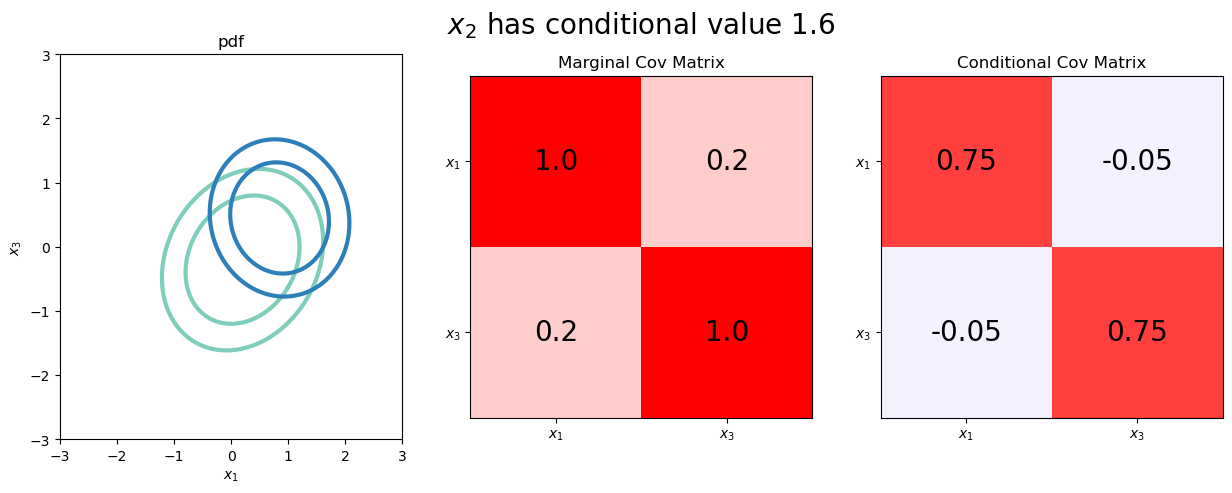

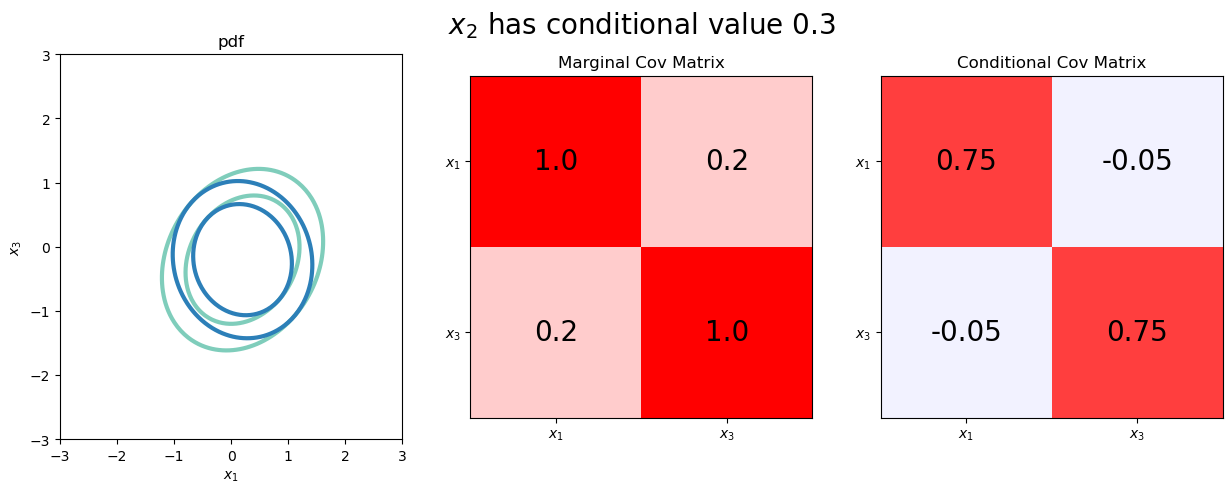

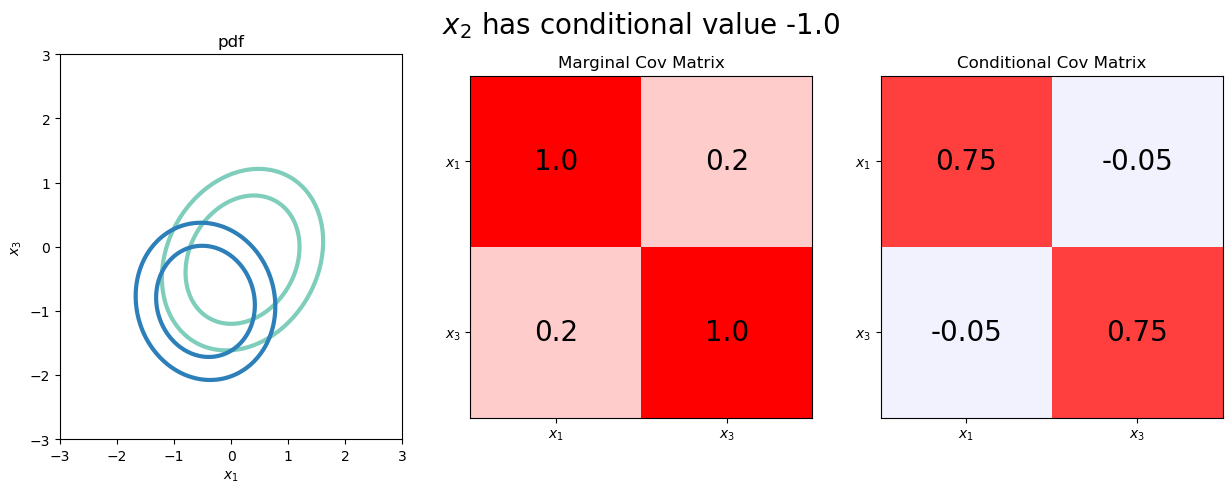

In [20]:
def plot_pdf_and_covariance(conditional_index:int, conditional_value:float):

    # Use the vectorized pdf evaluation. Keep this in mind for your projects in the future!
    marginal_evaluations = mg_pdf_vectorized(x_vec_points, mu_four, cov_four, marginal_index=conditional_index)
    conditional_evaluations = cg_pdf_vectorized(x_vec_points, mu_four, cov_four, conditional_index, conditional_value)
    
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].contour(x1_points, x3_points, marginal_evaluations/np.max(marginal_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors='#7fcdbb', linewidths=3)
    ax[0].contour(x1_points, x3_points, conditional_evaluations/np.max(conditional_evaluations), levels=[ np.exp(-1),np.exp(-0.5)], 
                  colors='#2c7fb8', linewidths=3)
    ax[0].set_xlabel(r'$x_1$')
    ax[0].set_ylabel(r'$x_3$')
    ax[0].set_title('pdf')

    _, cov_marginal = marginal_mean_covariance(mu_four, cov_four, marginal_index=conditional_index)
    ax[1].imshow(cov_marginal, cmap='bwr', vmax=1, vmin=-1)
    ax[1].set_xticks([0,1])
    ax[1].set_xticklabels([r'$x_1$',r'$x_3$'])
    ax[1].set_yticks([0,1])
    ax[1].set_yticklabels([r'$x_1$',r'$x_3$'])
    ax[1].set_title('Marginal Cov Matrix')
    for x_1 in range(2):
        for x_3 in range(2):
            ax[1].text(x_1, x_3, cov_marginal[x_1, x_3], fontsize=20, ha='center', va='center')

    ax[1].text(0.5, -0.8, r'$x_2$ has conditional value ' + f'{conditional_value}', fontsize=20, ha='center', va='center')

    _, cov_conditional = conditioned_mean_covariance(mu_four, cov_four, conditional_index, conditional_value)
    ax[2].imshow(cov_conditional, cmap='bwr', vmax=1, vmin=-1)
    ax[2].set_xticks([0,1])
    ax[2].set_xticklabels([r'$x_1$',r'$x_3$'])
    ax[2].set_yticks([0,1])
    ax[2].set_yticklabels([r'$x_1$',r'$x_3$'])
    ax[2].set_title('Conditional Cov Matrix')
    for x_1 in range(2):
        for x_3 in range(2):
            ax[2].text(x_1, x_3, np.round(cov_conditional[x_1, x_3],2), fontsize=20, ha='center', va='center')
    
    plt.show()

plot_pdf_and_covariance(1, 1.6)
plot_pdf_and_covariance(1, 0.3)
plot_pdf_and_covariance(1, -1.0)